In [5]:
from datasets import load_dataset, DatasetDict, load_from_disk
from PIL import Image
import numpy as np
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [3]:
# Load the dataset
ds = load_dataset("visual-layer/oxford-iiit-pet-vl-enriched")

# Inspect the dataset
print(ds)
print(ds['train'][0])  # Example of a single sample

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'label_cat_dog', 'label_breed', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 3680
    })
    test: Dataset({
        features: ['image_id', 'image', 'label_cat_dog', 'label_breed', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 3669
    })
})
{'image_id': 'Maine_Coon_204', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=389x500 at 0x168916580>, 'label_cat_dog': 'cat', 'label_breed': 'maine_coon', 'caption_enriched': 'a cat walking on grass', 'label_bbox_enriched': [{'bbox': [3, 3, 386, 497], 'label': 'cat'}], 'issues': []}


In [10]:
ds['test'][0]

{'image_id': 'newfoundland_31',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334>,
 'label_cat_dog': 'dog',
 'label_breed': 'newfoundland',
 'caption_enriched': 'a large black dog standing on a rock',
 'label_bbox_enriched': [{'bbox': [2, 1, 498, 331], 'label': 'tree'},
  {'bbox': [136, 38, 239, 296], 'label': 'dog'}],
 'issues': []}

In [12]:
TARGET_SIZE = 224  # Height, Width

def show_image_with_bbox(image, bbox, title=None):
    draw = ImageDraw.Draw(image)
    x, y, w, h = bbox
    draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

def resize_and_pad(image, bbox):
    original_width, original_height = image.size

    # Compute scale to fit within 224x224
    scale = min(TARGET_SIZE / original_width, TARGET_SIZE / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize image
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Compute padding
    pad_x = (TARGET_SIZE - new_width) // 2
    pad_y = (TARGET_SIZE - new_height) // 2

    # Create new padded image
    new_image = Image.new("RGB", (TARGET_SIZE, TARGET_SIZE), (0, 0, 0))
    new_image.paste(resized_image, (pad_x, pad_y))

    # Update bbox: [x_min, y_min, width, height]
    x_min, y_min, box_width, box_height = bbox
    x_min = x_min * scale + pad_x
    y_min = y_min * scale + pad_y
    box_width *= scale
    box_height *= scale

    new_bbox = [x_min, y_min, box_width, box_height]
    return new_image, new_bbox

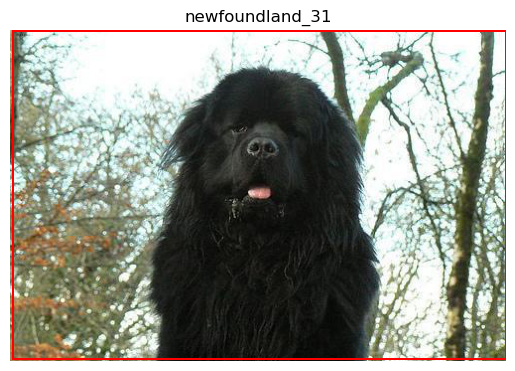

(500, 334)


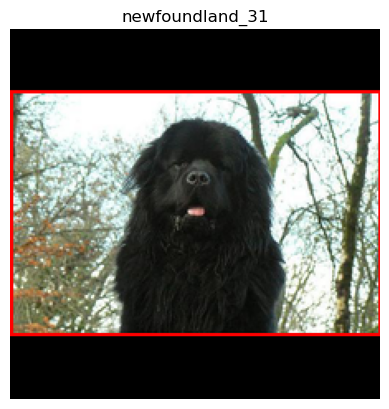

(224, 224)


In [15]:
example = ds["test"][0]
image = example["image"]
bbox = example["label_bbox_enriched"][0]['bbox']
show_image_with_bbox(image, bbox, title=example["image_id"])
print(image.size)
resized_img, new_bbox = resize_and_pad(image, bbox)
show_image_with_bbox(resized_img, new_bbox, title=example["image_id"])
print(resized_img.size)

In [30]:
def process_example(example):
    image = example['image']
    label_bbox_enriched = example['label_bbox_enriched']
    
    bbox = None
    for item in label_bbox_enriched:
        if item['label'] in {"cat", "dog"}:
            bbox = item['bbox']
            break  # stop after first cat/dog match

    resized_img, new_bbox = resize_and_pad(image, bbox=bbox)

    example['image'] = resized_img
    example['bbox'] = new_bbox
    return example

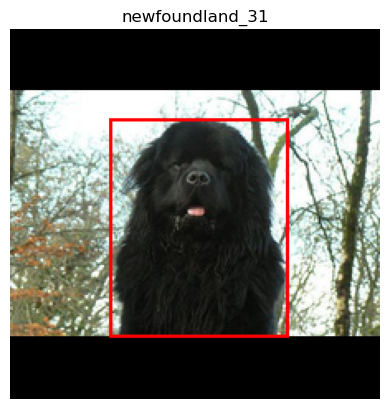

In [20]:
processed_example = process_example(ds['test'][0])

image = processed_example["image"]
bbox = processed_example['bbox']
show_image_with_bbox(image, bbox, title=processed_example["image_id"])

In [31]:
# Count how many have missing bboxes
missing_train = sum(1 for e in ds["train"] if e["label_bbox_enriched"] is None)
missing_test = sum(1 for e in ds["test"] if e["label_bbox_enriched"] is None)

print(f"Missing in train: {missing_train}")
print(f"Missing in test: {missing_test}")

Missing in train: 42
Missing in test: 43


In [32]:
# Filter out examples without bbox
dataset_clean = DatasetDict({
    "train": ds["train"].filter(lambda e: e["label_bbox_enriched"] is not None),
    "test": ds["test"].filter(lambda e: e["label_bbox_enriched"] is not None)
})

In [33]:
def has_cat_or_dog(example):
    return any(item["label"] in {"cat", "dog"} for item in example["label_bbox_enriched"])

filtered_dataset = DatasetDict({
    "train": dataset_clean["train"].filter(has_cat_or_dog),
    "test": dataset_clean["test"].filter(has_cat_or_dog),
})


Filter:   0%|          | 0/3638 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3626 [00:00<?, ? examples/s]

In [35]:
# Apply processing to both splits
processed_dataset = DatasetDict({
    "train": filtered_dataset["train"].map(process_example),
    "test": filtered_dataset["test"].map(process_example)
})

Map:   0%|          | 0/3513 [00:00<?, ? examples/s]

Map:   0%|          | 0/3511 [00:00<?, ? examples/s]

In [36]:
def show_example(example):
    img = example['image']
    bbox = example['bbox']
    draw = ImageDraw.Draw(img)
    x, y, w, h = bbox
    draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [38]:
processed_dataset.save_to_disk("resized_oxford_pets_224")

Saving the dataset (0/1 shards):   0%|          | 0/3513 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3511 [00:00<?, ? examples/s]

In [39]:
processed_dataset = load_from_disk("resized_oxford_pets_224")

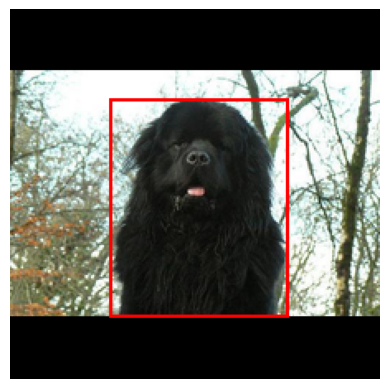

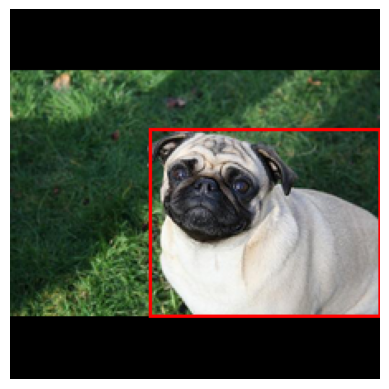

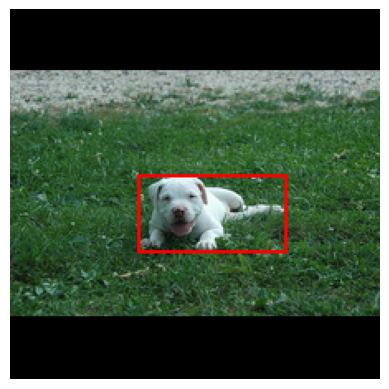

In [40]:
# Show a few
for i in range(3):
    show_example(processed_dataset["test"][i])

In [41]:
processed_dataset['test'][0]

{'image_id': 'newfoundland_31',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label_cat_dog': 'dog',
 'label_breed': 'newfoundland',
 'caption_enriched': 'a large black dog standing on a rock',
 'label_bbox_enriched': [{'bbox': [2, 1, 498, 331], 'label': 'tree'},
  {'bbox': [136, 38, 239, 296], 'label': 'dog'}],
 'issues': [],
 'bbox': [60.928000000000004, 54.024, 107.072, 132.608]}